## Generate Figure 3, for the sensitivity analysis manuscript 
In this notebook, we generate the third figure that includes results from one-at-a-time parameter perturbations. 

This figure has two main components: the $R\cos(\psi)$ model state outputs under various parameter values, and the heatmap showing a mean norm difference between state outputs with perturbed parameters and default parameters, for a given combination of parameter and light schedule. Recall that $R$ denotes the model amplitude output and $\psi$ denotes the model phase output, and each of these values are generated at every time point we consider. 

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev
import jax.numpy as jnp

# import the needed modules 
from hessian_normalized import HessianCircadian

from lightschedules import RegularLight
from lightschedules import ShiftWorkLight
from lightschedules import ShiftWorkerThreeTwelves
from lightschedules import SocialJetLag
from lightschedules import SlamShift

sens=HessianCircadian()
params = sens.get_parameters_array()

# define the light schedules 
ndays = 7
intensity = 979
dt = 0.10
ts=np.arange(0, 24*ndays, dt)
lights_rl = jnp.array([RegularLight(t, Intensity = intensity) for t in ts ]) # define the light schedules 
lights_sw = jnp.array([ShiftWorkLight(t,Intensity = intensity) for t in ts ])
lights_sw312 = jnp.array([ShiftWorkerThreeTwelves(t,Intensity = intensity) for t in ts ])
lights_sjl = jnp.array([SocialJetLag(t,Intensity = intensity) for t in ts ])
lights_ss = jnp.array([SlamShift(t,Intensity = intensity) for t in ts ])
lights_dark = jnp.zeros([len(ts),])

Previously, distributions for (some of) the model parameters had been generated via an MCMC framework. Here we read in the initial conditions and parameter distribution results from MCMC run of the model. 

We also create lists to specify which parameters we have distribution data from, and which we do not. 

In [2]:
# get stored initial conditions, generated in ics_generate.ipynb
%store -r ics_rl
%store -r ics_sw
%store -r ics_sw312
%store -r ics_sjl
%store -r ics_ss
%store -r ics_dark

# read in the mcmc results 
import pandas as pd

# read in the data 
mcmc_runs = pd.read_csv('mcmc_new_run_2022.csv', header = None, delimiter = '\t').to_numpy()
# list: tau, K, A1, A2, BetaL1, BetaL2, sigma, p, I0, alpha0, Beta1, ent_angle, cost, dd_period
mcmc_param_list = ["tau", "K", "A1", "A2", "BetaL1", "BetaL2", "sigma", "p", "I0", "alpha0", "Beta1", "ent_angle", "cost", "dd_period"]
model_param_list = ["tau", "K", "gamma", "Beta1", "A1", "A2", "BetaL1", "BetaL2", "sigma", "G", "alpha_0", "delta", "p", "I0"]

## Generate the model output plots with default and perturbed parameters
We iterate through the parameters and through percentiles of their MCMC distribution, when available. If not available we iterate through percentages of their default values. 

We compute the resulting model states (in the form of $R\cos(\psi)$, where $R$ is amplitude and $\psi$ is phase) with default parameter values and with perturbed parameter values, and compute a norm difference measurement between these.

0
1
2
3
4
5
6
7
8
9
10
11
12
13


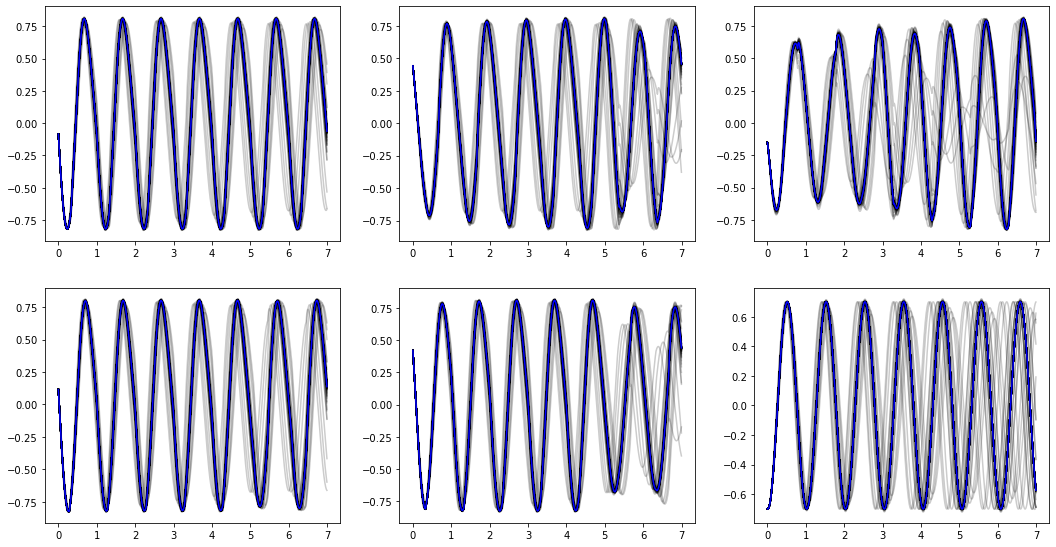

In [3]:
# initialize the figure 
fig, axes = plt.subplots(2, 3,figsize=(18, 9.5))
num_iter = 10 # number of iterations for each parameter

# find the model outputs with default parameters
model_states_all_rl_def = sens.step_all_n(ics_rl, lights_rl, params, dt)
model_states_all_sw_def = sens.step_all_n(ics_sw, lights_sw, params, dt)
model_states_all_sw312_def = sens.step_all_n(ics_sw312, lights_sw312, params, dt)
model_states_all_sjl_def = sens.step_all_n(ics_sjl, lights_sjl, params, dt)
model_states_all_ss_def = sens.step_all_n(ics_ss, lights_ss, params, dt)
model_states_all_dark_def = sens.step_all_n(ics_dark, lights_dark, params, dt)

# initialize the output measurements with perturbed parameters
norm_diff_rl = np.zeros([len(params),num_iter])
norm_diff_sw = np.zeros([len(params),num_iter])
norm_diff_sw312 = np.zeros([len(params),num_iter])
norm_diff_sjl = np.zeros([len(params),num_iter])
norm_diff_ss = np.zeros([len(params),num_iter])
norm_diff_dark = np.zeros([len(params),num_iter])

# norm difference measurement between model states 
def norm_diff_states(model_states_default, model_states_perturbed):
    
    x1 = model_states_perturbed[:,0] * jnp.cos(model_states_perturbed[:,1])
    y1 = model_states_perturbed[:,0] * jnp.sin(model_states_perturbed[:,1])
    x2 = model_states_default[:,0] * jnp.cos(model_states_default[:,1])
    y2 = model_states_default[:,0] * jnp.sin(model_states_default[:,1])
    norm_diff = np.mean((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    return norm_diff

# loop through the parameters and iterations 
for j in range(len(params)):
    
    print(j)
    
    for m in range(num_iter):
        
        param_name = model_param_list[j]
        rand_percent_vec = 0.96+m*0.01
        params_perturb = params
        
        if param_name in mcmc_param_list: 
            
            index = mcmc_param_list.index(param_name)
            med_val = np.quantile(mcmc_runs[:,index],0.50) 
            def_val = params[j] 
            shift = med_val - def_val
            params_perturb = params_perturb.at[j].set(np.quantile(mcmc_runs[:,index],(m+0.5)/num_iter) - shift) # simplify
            
        else:
            
            params_perturb = params_perturb.at[j].set(params[j]*rand_percent_vec)
        
        # RL schedule 
        model_states_all_new_rl = sens.step_all_n(ics_rl, lights_rl, params_perturb, dt)
        axes[0][0].plot(ts/24,model_states_all_new_rl[:,0]*np.cos(model_states_all_new_rl[:,1]),'k',label = 'RL', alpha = 0.2)
        norm_diff_rl[j,m] = norm_diff_states(model_states_all_rl_def, model_states_all_new_rl)
        
        # SW schedule 
        model_states_all_new_sw = sens.step_all_n(ics_sw, lights_sw, params_perturb, dt)
        axes[0][1].plot(ts/24,model_states_all_new_sw[:,0]*np.cos(model_states_all_new_sw[:,1]),'k',label = 'SW', alpha = 0.2)
        norm_diff_sw[j,m] = norm_diff_states(model_states_all_sw_def, model_states_all_new_sw)
        
        # SW312 schedule 
        model_states_all_new_sw312 = sens.step_all_n(ics_sw312, lights_sw312, params_perturb, dt)
        axes[0][2].plot(ts/24,model_states_all_new_sw312[:,0]*np.cos(model_states_all_new_sw312[:,1]),'k',label = 'SW312', alpha = 0.2)
        norm_diff_sw312[j,m] = norm_diff_states(model_states_all_sw312_def, model_states_all_new_sw312)
        
        # SJL schedule
        model_states_all_new_sjl = sens.step_all_n(ics_sjl, lights_sjl, params_perturb, dt)
        axes[1][0].plot(ts/24,model_states_all_new_sjl[:,0]*np.cos(model_states_all_new_sjl[:,1]),'k',label = 'SJL', alpha = 0.2)
        norm_diff_sjl[j,m] = norm_diff_states(model_states_all_sjl_def, model_states_all_new_sjl)
        
        # SS schedule
        model_states_all_new_ss = sens.step_all_n(ics_ss, lights_ss, params_perturb, dt)
        axes[1][1].plot(ts/24,model_states_all_new_ss[:,0]*np.cos(model_states_all_new_ss[:,1]),'k',label = 'SS', alpha = 0.2)
        norm_diff_ss[j,m] = norm_diff_states(model_states_all_ss_def, model_states_all_new_ss)
        
        # Dark schedule
        model_states_all_new_dark = sens.step_all_n(ics_dark, lights_dark, params_perturb, dt)
        axes[1][2].plot(ts/24,model_states_all_new_dark[:,0]*np.cos(model_states_all_new_dark[:,1]),'k',label = 'Dark', alpha = 0.2)
        norm_diff_dark[j,m] = norm_diff_states(model_states_all_dark_def, model_states_all_new_dark)

# plot default parameter state outputs 
axes[0][0].plot(ts/24,model_states_all_rl_def[:,0]*np.cos(model_states_all_rl_def[:,1]),'b',label = 'RL')
axes[0][1].plot(ts/24,model_states_all_sw_def[:,0]*np.cos(model_states_all_sw_def[:,1]),'b',label = 'SW')
axes[0][2].plot(ts/24,model_states_all_sw312_def[:,0]*np.cos(model_states_all_sw312_def[:,1]),'b',label = 'SW312')
axes[1][0].plot(ts/24,model_states_all_sjl_def[:,0]*np.cos(model_states_all_sjl_def[:,1]),'b',label = 'SJL')
axes[1][1].plot(ts/24,model_states_all_ss_def[:,0]*np.cos(model_states_all_ss_def[:,1]),'b',label = 'SS')
axes[1][2].plot(ts/24,model_states_all_dark_def[:,0]*np.cos(model_states_all_dark_def[:,1]),'b',label = 'Dark')
#plt.savefig('figures_8_29/r_cos_psi_all_schedules_v3.svg')
plt.show()

In gray we see the perturbed parameter model outputs for the six schedules of interest over 7 days, while the default parameter model outputs are shown in blue. 

## Generate norm difference results for the perturbed parameters
Here we compute the mean norm difference, first averaged across parameters and parameter iterations to generate six values (one for each light schedule). Then we average across parameter iterations only to generate individual values for each parameter and light schedule combination. 

Mean norm difference for the six light schedules is given by:
[0.014120220541251489, 0.02063574421255545, 0.021761758032257005, 0.015168834779951856, 0.01603102425016369, 0.03822807454695253]


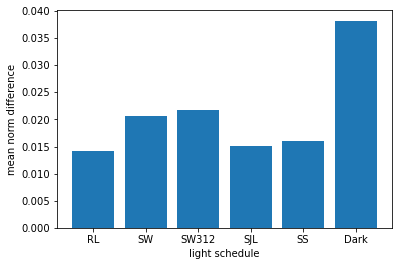

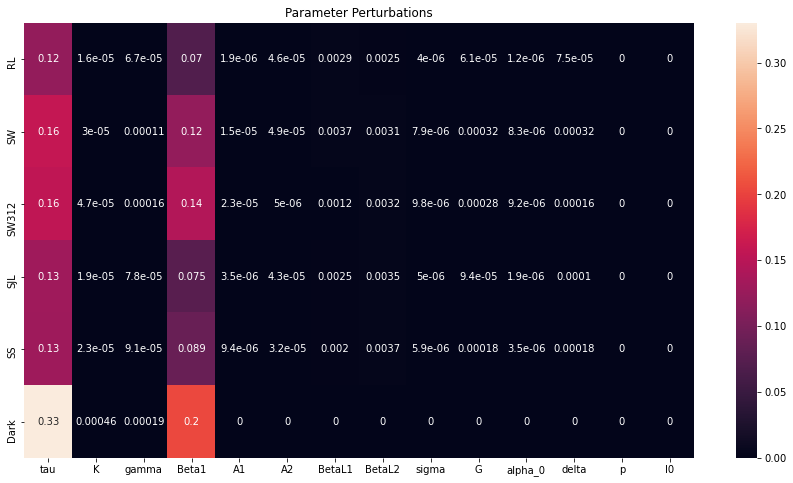

In [9]:
norm_diff_mean = [np.mean(norm_diff_rl), np.mean(norm_diff_sw), np.mean(norm_diff_sw312), np.mean(norm_diff_sjl), np.mean(norm_diff_ss), np.mean(norm_diff_dark)]
num_schedules = 6

print('Mean norm difference for the six light schedules is given by:')
print(norm_diff_mean)

plt.bar(range(num_schedules),norm_diff_mean)
plt.xlabel('light schedule')
plt.ylabel('mean norm difference')
plt.xticks(range(num_schedules),['RL','SW','SW312','SJL','SS','Dark'])
plt.show()

import seaborn as sns 
labels = ['tau', 'K', 'gamma', 'Beta1', 'A1', 'A2', 'BetaL1',
                  'BetaL2', 'sigma', 'G', 'alpha_0', 'delta', 'p', 'I0']
param_sens2 = np.zeros([num_schedules,len(params)])
param_sens2[0,:] = np.mean(norm_diff_rl, axis = 1)
param_sens2[1,:] = np.mean(norm_diff_sw, axis = 1)
param_sens2[2,:] = np.mean(norm_diff_sw312, axis = 1)
param_sens2[3,:] = np.mean(norm_diff_sjl, axis = 1)
param_sens2[4,:] = np.mean(norm_diff_ss, axis = 1)
param_sens2[5,:] = np.mean(norm_diff_dark, axis = 1)
plt.figure(figsize = (15,8))
ax = sns.heatmap(param_sens2,annot = True)
ax.set_yticklabels(['RL','SW','SW312','SJL','SS','Dark'])
ax.set_xticklabels(labels)
plt.title('Parameter Perturbations')
#plt.savefig('figures_8_29/norm_diff_avg_v3.svg')
plt.show()

We see the mean norm difference results from one-at-a-time parameter perturbations plotted above. Interestingly, when these are averaged across parameter and parameter perturbations to generate one value for each light schedule, we see a very similar picture to the hessian-based approach in terms of overall sensitivity. Specifically, the constant darkness schedule is the most sensitive by far, followed by the shift work schedules, the slam shift schedule, the social jet lag schedule, and the regular light schedule. 

If we average instead for each parameter/light schedule pair, we see that the parameters of $\tau$ and $\beta1$ seem to yield the largest norm differences under parameter changes. 